In [46]:
import GLDF
import numpy as np
import matplotlib.pyplot as plt

# Tutorial 03: Custom Patterns - Approximate Periodicity

Our framework can deal with very general prior structures about patterns.
This tutorial demonstrates how to describe a custom pattern on the example of (approximate) periodic in time patterns.
To this end we
1. Describe our prior knowledge about the pattern in a formal way.
2. Configure HCCD to run with this custom pattern.

For readability we will represent periodicity-patterns by strings, relevant properties can readily be extracted, for example:

In [47]:
repeating_pattern = "AACBCC"

## 1. The Pattern

We first have to formalize what "approximately periodic" means.
We can do so by implementing a derived class of data_management.CIT_DataPatterned.

As described in the documentation, we have to implement (at least) three methods:

*   view_blocks: This is the core functionality. It encodes our prior idea about patterns
    by supplying "blocks" (of a given size) of "similar" data-points.
    Similar, in our case, are data-points that follow the periodic pattern.
    For example if the approximate pattern is 'AAB' we expect regimes in data to "usually" (but not always)
    follow the structure AAB AAB AAB AAB AAB AAB AAB AAB (spaces for readability).
    Now, if we want blocks of "similar" points of, say, size 8 from this sequence, we should consider
    for example

    *   block No1: XX. XX. XX. XX. ... ... ... ... (8 data-points, all from 'A')
    *   block No2: ... ... ... ... XX. XX. XX. XX. (8 data-points, all from 'A')
    *   block No3: ..X ..X ..X ..X ..X ..X ..X ..X (8 data-points, all from 'B')
    *   for the remaineder of the data, repeat this logic, collecting further blocks (possibly discarding some data-points in the end if rounding-issues occur).

    The code below is a simple (albeit likely not particular efficient) implementation of this strategy.

*   static reproject_blocks: This describes how results on blocks can be "reprojected" onto the time-axis for plotting. (This can be a static function on the patterned data,
    or an arbitrary method of a factory-object as shown below on 'Pattern_PeriodicPersistent'.)
*   get_actual_block_format: Blocks could be two-dimensional, in which case their format is not (for plotting purposes)
    fully described by their size. In our case, we simply copy through the requested size.

### 1.1 Analyizing Pattern-Strings

Consider the following example:

In [48]:
repeating_pattern = "AACBCC"

pattern_len = len(repeating_pattern)
repeating_elements = set(repeating_pattern) # letters in pattern, eg {A, B, C} for pattern AABCCC
repetitions = {elem: repeating_pattern.count(elem) for elem in repeating_elements} # number of occurences of letters per period, eg {A:2, B:1, C:3}
masks = {elem: np.array(list(repeating_pattern))==elem for elem in repeating_elements}

print(repeating_pattern)
print(pattern_len)
print(repeating_elements)
print(repetitions)
print(masks)

AACBCC
6
{'B', 'A', 'C'}
{'B': 1, 'A': 2, 'C': 3}
{'B': array([False, False, False,  True, False, False]), 'A': array([ True,  True, False, False, False, False]), 'C': array([False, False,  True, False,  True,  True])}


Generally, the following helper provides this kind of quick analysis:

In [49]:
class Pattern_PeriodicPersistent_Analyize:
    def __init__(self, repeating_pattern: str, N: int):
        self.N = N
        self.repeating_pattern = repeating_pattern
        self.pattern_len = len(repeating_pattern)
        self.repeating_elements = set(repeating_pattern) # letters in pattern, eg {A, B, C} for pattern AABCCC
        self.repetitions = {elem: repeating_pattern.count(elem) for elem in self.repeating_elements} # number of occurences of letters per period, eg {A:2, B:1, C:3}
        self.masks = {elem: np.array(list(repeating_pattern))==elem for elem in self.repeating_elements}
        self.full_masks = {elem: self.repeat_mask(mask) for elem, mask in self.masks.items()}
            
    def repeat_mask(self, mask):
        result = np.empty(self.N, dtype=bool)
        full_repetitions = int(len(result)/self.pattern_len)
        result[:full_repetitions*self.pattern_len] = np.tile(mask, full_repetitions)
        result[full_repetitions*self.pattern_len+1:] = mask[:len(result)-full_repetitions*self.pattern_len]
        return result
    
    def count_blocks_for_element(self, element, block_size) -> int:
        return int(np.count_nonzero(self.full_masks[element])/block_size)

### 1.2 The Patterned Data

The view_blocks method (and its per-element analogue _view_blocks_element) provides the main functionality, as described above.

In [50]:
class CIT_DataPatterned_PeriodicPersistent(GLDF.data_management.CIT_DataPatterned, Pattern_PeriodicPersistent_Analyize):
    def __init__(self, repeating_pattern: str, **args):
        GLDF.data_management.CIT_DataPatterned.__init__(self, **args)
        Pattern_PeriodicPersistent_Analyize.__init__(self, repeating_pattern, self.sample_count())


    def _view_blocks_element(self, element, block_size) -> np.ndarray:
        block_count = self.count_blocks_for_element(element, block_size)
        aligned_N = block_size * block_count

        data_masked_x = self.x_data[self.full_masks[element]]
        blocks_x = data_masked_x[:aligned_N].reshape((block_count, block_size))
        data_masked_y = self.y_data[self.full_masks[element]]
        blocks_y = data_masked_y[:aligned_N].reshape((block_count, block_size))
        if self.z_dim() > 0:
            data_masked_z = self.z_data[self.full_masks[element],:]
            blocks_z = data_masked_z[:aligned_N,:].reshape((block_count, block_size,-1))
        else:
            blocks_z = None

        return blocks_x, blocks_y, blocks_z


    def view_blocks(self, block_size:int) -> GLDF.data_management.BlockView:
        all_blocks_x = []
        all_blocks_y = []
        all_blocks_z = []
        for elem in self.repeating_elements:
            blocks_x, blocks_y, blocks_z = self._view_blocks_element(elem, block_size)
            all_blocks_x.append(blocks_x)
            all_blocks_y.append(blocks_y)
            all_blocks_z.append(blocks_z)
        return GLDF.data_management.BlockView(
            pattern_provider=self,
            cache_id=None if self.cache_id is None else (*self.cache_id, block_size),
            x_blocks=np.vstack(all_blocks_x),
            y_blocks=np.vstack(all_blocks_y),
            z_blocks=np.vstack(all_blocks_z) if self.z_dim() > 0 else None
        )
    
    @staticmethod
    def get_actual_block_format(requested_size: int) -> int:
        return requested_size

### 1.3 Factory Object
Finally, we wrap the above pattern into a factory-object and provide reprojection-logic for plotting.

In [51]:
class Pattern_PeriodicPersistent:
    def __init__(self, repeating_pattern: str):
        self.repeating_pattern = repeating_pattern

    def __call__(self, **args):
        return CIT_DataPatterned_PeriodicPersistent(repeating_pattern=self.repeating_pattern, **args)
    
    def reproject_blocks(self, value_per_block: np.ndarray, block_configuration: GLDF.data_management.BlockView, data_configuration: tuple[int,...]) -> dict[str, np.ndarray]:
        analyize = Pattern_PeriodicPersistent_Analyize(self.repeating_pattern, N=block_configuration.pattern_provider.sample_count()) # patterned-data sample-size accounts for tau-max (window-count < N)
        
        block_size = block_configuration.block_size()
        read_offset = 0
        results = {}

        for elem in analyize.repeating_elements:
            block_count = analyize.count_blocks_for_element(elem, block_size)
            elem_values = value_per_block[read_offset:read_offset+block_count]
            read_offset += block_count
            result = np.full( data_configuration, float("nan") )
            renorm_block_size = int(block_size*analyize.pattern_len/analyize.repetitions[elem])
            result[:block_count*renorm_block_size] = elem_values.repeat(renorm_block_size)
            results[elem] = result

        return results

## 2. Modify the Configuration

As a simple application of what is also explained in the second tutorial, we add a configuration using the above pattern in HCCD.
The pattern is actually associated to the data-manager, indeed we can use the default (time-series) data-manager
and provide the pattern in its constructor:

In [52]:
class ConfigureHCCD_PeriodicPersistent(GLDF.frontend.ConfigureHCCD):
    def __init__(self, regimes_are_large: bool=True, alpha: float=0.01, alpha_pc1: float=0.1, repeating_pattern: str="AB"):
        ts_config = GLDF.frontend.configure_hccd_temporal_regimes(regimes_are_large=regimes_are_large, alpha=alpha, alpha_pc1=alpha_pc1)
        from dataclasses import asdict
        super().__init__(**asdict(ts_config))
        self.repeating_pattern = repeating_pattern

    def get_data_manager(self):
        return GLDF.data_management.DataManager_NumpyArray_Timeseries(self._data, pattern=Pattern_PeriodicPersistent(self.repeating_pattern))

In [53]:
import numpy as np

N = 1000

# At odd times, in last quarter [second half]
R1 = np.mod( np.arange(N), 2 ) == 1
R1[:int(3*N/4)] = False

# and even times always [outside first and last quarter]
R2 = np.mod( np.arange(N), 2 ) == 0
#R2[:int(N/4)] = False
#R2[int(3*N/4):] = False

# the context is "on":
R = np.logical_or(R1, R2)


rng = np.random.default_rng()
X_noise = rng.standard_normal(N)
Y_noise = rng.standard_normal(N)
Z_noise = rng.standard_normal(N)

X = np.empty_like(X_noise)
Y = np.empty_like(Y_noise)
Z = np.empty_like(Z_noise)

def lag_one_or_zero(values, t):
    return values[t-1] if t > 0 else 0.0

for t in range(N):
    X[t] = X_noise[t] + 0.2 * lag_one_or_zero(X, t)
    Z[t] = Z_noise[t]
    Y[t] = Y_noise[t] + R[t] * lag_one_or_zero(X, t) + Z[t]

data = np.array([X,Y,Z]).T
var_names = ["X", "Y", "Z"]

Commented out lines: If only using eg half the data at odd times, only about a quarter of data remains, which especially for "small" N, may not suffice.
In principle even times can have regimes independently, these are currently commented out, because otherwise persistent regimes also work (in principle/for infinite N at least).

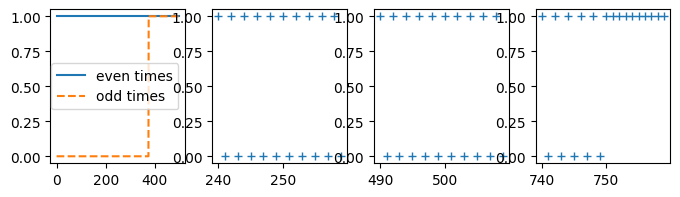

In [54]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(8,2))

for ax_i in ax:
    ax_i.set_ylim(-0.05, 1.05)

ax[0].plot(R[::2], label="even times")
ax[0].plot(R[1::2], label="odd times", linestyle="dashed")
ax[0].legend()

ax[1].plot(np.arange(20)+240, R[240:260], '+')
ax[2].plot(np.arange(20)+490, R[490:510], '+')
ax[3].plot(np.arange(20)+740, R[740:760], '+')

plt.show()

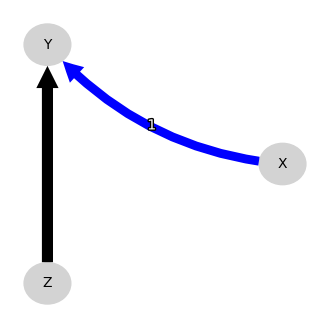

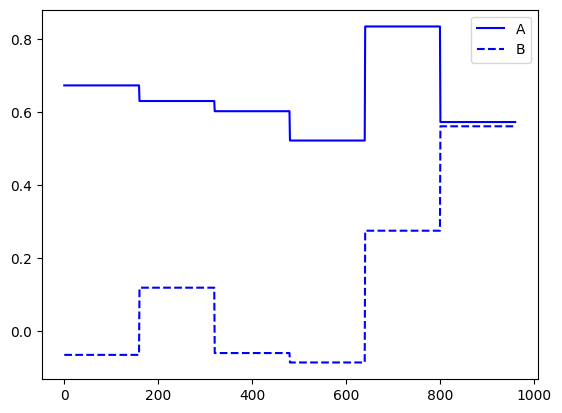

In [55]:
config = ConfigureHCCD_PeriodicPersistent(repeating_pattern="AB")
config.indicator_resolution_granularity = 80

result = config.run(data)
result.var_names = var_names
import matplotlib.pyplot as plt
result.plot_labeled_union_graph()
plt.show()
for mi in result.model_indicators():
    mi.plot_resolution()
    plt.legend()
    plt.show()

Indicator-resolution can be poor, especially when indicator_resolution_granularity is chosen poorly, considering that given N=1000 there are 998 (max-length, including PC1-parents for MCI tests) windows, eg using indicator_resolution_granularity=100 (the default) leaves a remainder of 98 data-points ..., effectively (per odd/even sub-dataset) blocks have temporal extension 2*indicator_resolution_granularity, which reinforces this issue.